# Regression showdown

In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from itertools import product
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ModuleNotFoundError: No module named 'augly'

In [2]:
import hparam_tune_ekf as hp_ekf
import hparam_tune_lofi as hp_lofi

ModuleNotFoundError: No module named 'bayes_opt'

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [43]:
def tree_to_cpu(tree):
    return jax.tree_map(np.array, tree)

def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)

In [11]:
# dataset = "wine"
# train, test = datasets.load_uci_wine_regression()

# dataset = "power"
# train, test = datasets.load_uci_power()

dataset = "kin8nm"
train, test = datasets.load_uci_kin8nm()

# dataset = "naval"
# train, test = datasets.load_uci_naval()

# dataset = "rmnist_2"
# train, test = datasets.load_rotated_mnist(frac_train=0.8, num_train=None, target_digit=[0,1,2,3,4], sort_by_angle=False)

In [12]:
%%time
dataset = "kin8nm"
train, test = datasets.load_uci_kin8nm()
data, csts = datasets.showdown_preprocess(train, test, n_warmup=1000, n_test_warmup=300)

ymean = csts["ymean"]
ystd = csts["ystd"]

warmup_train = data["warmup_train"]
warmup_test = data["warmup_test"]
X_learn, y_learn = data["train"]
X_test, y_test = data["test"]

CPU times: user 102 ms, sys: 10.7 ms, total: 113 ms
Wall time: 184 ms


In [13]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean(),
    }
    return res

In [14]:
def eval_callback(bel, pred, t, X, y, bel_pred, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]    
    yhat_test = apply_fn(bel.mean, X_test).squeeze()
    
    # Compute errors
    y_test = y_test * ystd + ymean
    yhat_test = yhat_test.ravel() * ystd + ymean
    
    y_next = y.ravel() * ystd + ymean
    #yhat_next = pred.mean.ravel() * ystd + ymean
    yhat_next = pred.ravel() * ystd + ymean
    
    err_test = jnp.abs(y_test - yhat_test)
    err = jnp.abs(y_next - yhat_next).sum()
    
    
    res = {
        "test": err_test.mean(),
        "osa-error": err,
    }
    return res

## Test setup

In [9]:
key = jax.random.PRNGKey(314)


In [24]:
agents = {}
agents_beliefs = {}
agents_output = {}

```
dynamics_weights: gamma
init_cov: eta
emission_cov: r
dynamics_cov: q (steady-state assumption)
```

In [17]:
pbounds = {
    "log_init_cov": (-5, 0.0),
    "dynamics_weights": (0, 1.0),
    "log_emission_cov": (-7, 0.0),
    "dynamics_log_cov": (-7, 0.0),
}

pbounds_lofi = pbounds.copy()
pbounds_lofi.pop("dynamics_log_cov");

In [18]:
dynamics_weights = [0.0, 0.5, 1.0] # gamma
log_init_cov = np.log([0.01, 0.1, 1.0]) # eta
log_emission_cov = np.log([0.01, 0.1, 1.0]) # R

elements = product(dynamics_weights, log_init_cov, log_emission_cov)
probe_points = [{
    "dynamics_weights": gamma,
    "log_init_cov": log_eta,
    "log_emission_cov": log_R
} for gamma, log_eta, log_R in elements]


elements = product(dynamics_weights, log_init_cov)
probe_points_adapted = [{
    "dynamics_weights": gamma,
    "log_init_cov": log_eta
} for gamma, log_eta in elements]


probe_points = []
n_init_points = 5 if len(probe_points) > 0 else 10
n_gp = 15

## Model setup

In [19]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
dim_out = 1
_, dim_in = X_learn.shape
model = MLP(dim_out, activation=nn.elu)

In [20]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)

# Agent showdown

## Diag-EKF

In [21]:
optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method="fdekf",
)

In [22]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.9849   | -0.5819   | 0.5885    | -5.145    | -1.084    |
| 2         | -0.9235   | -0.574    | 0.8274    | -1.904    | -3.698    |
| 3         | -0.8838   | -0.6177   | 0.2608    | -1.635    | -3.692    |
| 4         | -0.816    | -6.144    | 0.386     | -1.119    | -3.609    |
| 5         | -0.8154   | -6.511    | 0.6331    | -2.907    | -2.094    |
| 6         | -0.9006   | -2.26     | 0.6872    | -3.928    | -3.395    |
| 7         | -0.8153   | -3.006    | 0.4798    | -0.9725   | -0.826    |
| 8         | -0.8157   | -6.26     | 0.06041   | -2.822    | -1.038    |
| 9         | -0.8552   | -5.416    | 0.5352    | -6.048    | -3.139    |
| 10        | -0.8159   | -5.936    | 0.4298    | -1.451    | -2.965    |
| 11        | -0.5666   | -6.745    | 1.0       | 0.0       | 0.0       |
| 12        | -0.6074   | -5.625    | 

In [25]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

name_agent = "ekf-fd"
hparams = hp_ekf.get_best_params(n_params, optimizer, method="fdekf")
agent = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fdekf")
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.0893


## LoFi (orth / fixed)

In [26]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds_lofi, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [27]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.8255   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.8271   | 0.7832    | -0.574    | -0.8632   |
| 3         | -0.9794   | 0.728     | -5.177    | -0.4412   |
| 4         | -0.8153   | 0.2608    | -1.635    | -3.692    |
| 5         | -0.979    | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.9866   | 0.2782    | -6.511    | -1.834    |
| 7         | -0.8483   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.8216   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.9547   | 0.5706    | -3.641    | -0.6946   |
| 10        | -3.069    | 0.8348    | -6.26     | -4.698    |
| 11        | -0.6079   | 1.0       | 0.0       | -5.0      |
| 12        | -0.548    | 1.0       | 0.0       | -2.931    |
| 13        | -0.9919   | 0.0       | -7.0      | 0.0       |
| 14        | -0.8158   | 0.0       | 0.0       | -3.934    |
| 15    

In [28]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

name_agent = "lofi-orth"
hparams = hp_lofi.get_best_params(n_params, optimizer)
agent = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.0887


## LoFi (full / fixed)

In [29]:
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds_lofi, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [30]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | log_em... | log_in... |
-------------------------------------------------------------
| 1         | -0.8461   | 0.9169    | -2.88     | -3.675    |
| 2         | -0.8272   | 0.7832    | -0.574    | -0.8632   |
| 3         | -10.0     | 0.728     | -5.177    | -0.4412   |
| 4         | -0.8153   | 0.2608    | -1.635    | -3.692    |
| 5         | -0.9789   | 0.1223    | -4.298    | -0.7996   |
| 6         | -0.9869   | 0.2782    | -6.511    | -1.834    |
| 7         | -0.8646   | 0.5848    | -2.931    | -1.614    |
| 8         | -0.8335   | 0.6872    | -3.928    | -3.395    |
| 9         | -0.946    | 0.5706    | -3.641    | -0.6946   |
| 10        | -0.8444   | 0.8348    | -6.26     | -4.698    |
| 11        | -0.8464   | 0.8334    | -6.282    | -4.649    |
| 12        | -0.9505   | 0.0       | -3.928    | -1.862    |
| 13        | -0.8467   | 0.0       | -2.671    | -2.813    |
| 14        | -0.8234   | 0.7484    | -1.45     | -2.236    |
| 15    

In [31]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

name_agent = "lofi-full"
hparams = hp_lofi.get_best_params(n_params, optimizer)
agent = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.0766


## ORFit

In [33]:
method = "orfit"
params_orfit = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)


name_agent = "orfit"
agent = lofi.RebayesLoFi(params_orfit, params_lofi, method=method)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.0967


## FC-EKF

In [34]:
optimizer, apply_fn, n_features = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method="fcekf"
)

In [35]:
%%time
# Probe points
for ppoint in probe_points:
    optimizer.probe(ppoint, lazy=True)

optimizer.maximize(
    init_points=n_init_points,
    n_iter=n_gp,
)

|   iter    |  target   | dynami... | dynami... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.9849   | -0.5819   | 0.5885    | -5.145    | -1.084    |
| 2         | -0.8685   | -0.574    | 0.8274    | -1.904    | -3.698    |
| 3         | -0.8838   | -0.6177   | 0.2608    | -1.635    | -3.692    |
| 4         | -0.816    | -6.144    | 0.386     | -1.119    | -3.609    |
| 5         | -0.8154   | -6.511    | 0.6331    | -2.907    | -2.094    |
| 6         | -0.9006   | -2.26     | 0.6872    | -3.928    | -3.395    |
| 7         | -0.8153   | -3.006    | 0.4798    | -0.9725   | -0.826    |
| 8         | -0.8157   | -6.26     | 0.06041   | -2.822    | -1.038    |
| 9         | -0.8552   | -5.416    | 0.5352    | -6.048    | -3.139    |
| 10        | -0.8159   | -5.936    | 0.4298    | -1.451    | -2.965    |
| 11        | -0.4114   | -7.0      | 1.0       | 0.0       | 0.0       |
| 12        | -0.4463   | -6.029    | 

In [36]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

name_agent = "ekf-fc"
hparams = hp_ekf.get_best_params(n_params, optimizer, method="fcekf")
agent = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fcekf")
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

0.0655


## L-RVGA

In [54]:
import distrax

In [55]:
def fwd_link(mean, bel, x):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std ** 2

def log_prob(mean, bel, x, y):
    yhat, std = fwd_link(mean, bel, x)
    std = jnp.sqrt(std)
    
    logp = distrax.Normal(yhat, std).log_prob(y).sum()
    return logp

In [100]:
hparams = {
    "sigma2": 0.01,
    "eps": 1e-4
}

std = 0.6
dim_rank = 50
bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_learn, dim_rank, std, **hparams)

In [101]:
name_agent = f"l-rvga"
agent = lrvga.LRVGA(fwd_link, log_prob, n_samples=30, n_outer=1, n_inner=3)
bel, output = agent.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=True, bel=bel_init, **test_kwargs
)

agents[name_agent] = agent
agents_output[name_agent] = output
agents_beliefs[name_agent] = bel

metric_final = output["test"][-1]
print(f"{metric_final:=0.4f}")

  0%|          | 0/5554 [00:00<?, ?it/s]

0.0954


## Plot results

In [102]:
colors = plt.cm.tab10(np.linspace(0, len(agents)))
colors = {
    name_agent: color
    for name_agent, color
    in zip(agents, colors)
}

In [103]:
data = get_subtree(agents_output, "test")
data = tree_to_cpu(data)
data = pd.DataFrame(data)

In [104]:
data.tail()

,ekf-fc,ekf-fd,l-rvga,lofi-full,lofi-orth,orfit
5549,0.065515,0.089096,0.095606,0.076279,0.093444,0.100103
5550,0.065515,0.089316,0.095703,0.076204,0.091722,0.099916
5551,0.065520,0.089216,0.095694,0.076342,0.088986,0.095870
5552,0.065505,0.089283,0.095614,0.076520,0.088179,0.094320
5553,0.065496,0.089313,0.095443,0.076551,0.088662,0.096685


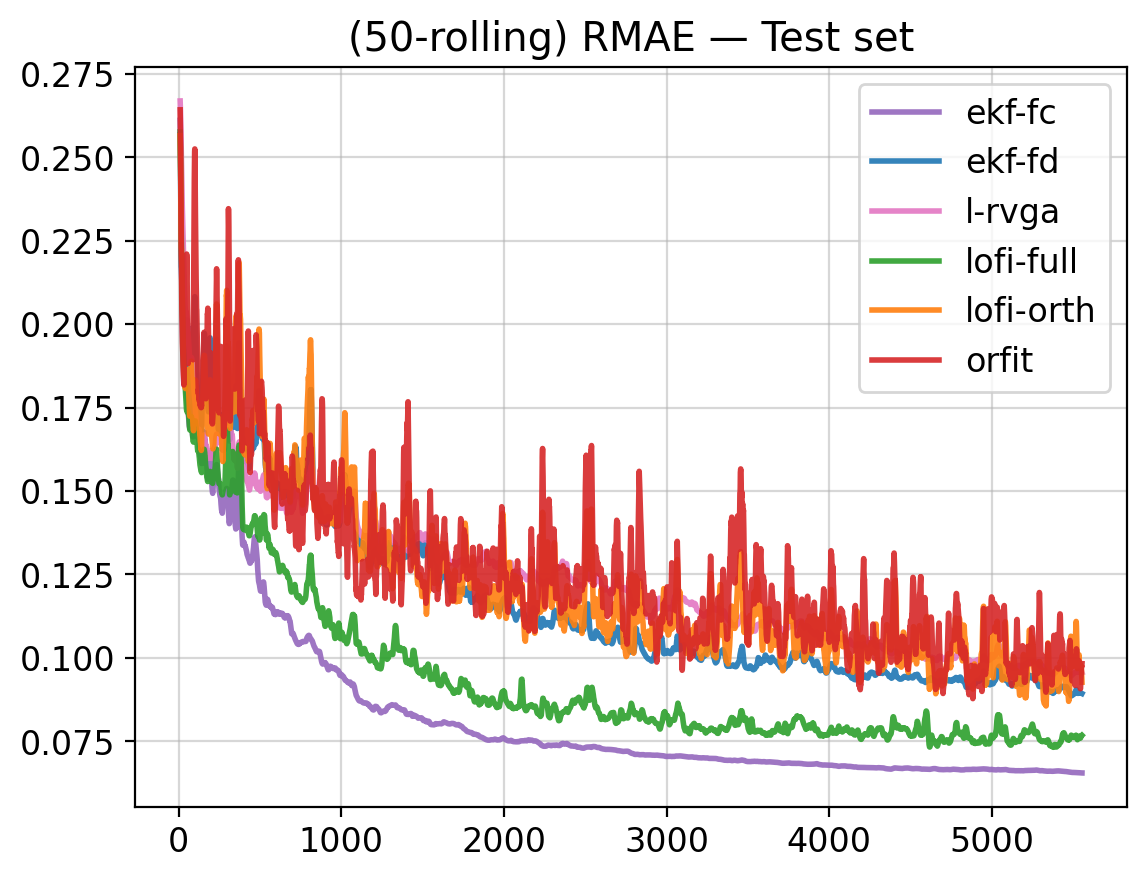

In [105]:
data.rolling(10).mean().plot(color=colors, alpha=0.9)
plt.title(f"(50-rolling) RMAE — Test set")
plt.grid(alpha=0.5)

# Simulations

In [114]:
def eval_runs(key, num_runs_pc, estimator):
    num_devices = jax.device_count()
    num_sims = num_runs_pc * num_devices
    keys = jax.random.split(key, num_sims).reshape(-1, num_devices, 2)
    n_vals = len(X_learn)
    
    @partial(jax.pmap, in_axes=1)
    @partial(jax.vmap, in_axes=0)
    def evalf(key):
        key_shuffle, key_init = jax.random.split(key)
        ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
        
        params = model.init(key, jnp.ones((1, dim_in)))
        flat_params, _ = ravel_pytree(params)
        
        n_params = len(flat_params)

        bel, output = estimator.scan(
            X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=eval_callback, progress_bar=False, **test_kwargs
        )
        return output
    
    
    outputs = evalf(keys)
    outputs = jax.tree_map(lambda x: x.reshape(num_sims, -1), outputs)
    return outputs

In [115]:
def plot_sims(data, ax, color, label, rolling=100):
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    sims = data.rolling(rolling).mean().values
    plt.plot(sims, c=color, alpha=0.07, linewidth=1)

In [116]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 2 * std_sim
    ubound = mean_sim + 2 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

## Run simulations

In [117]:
agents = {
    "lofi-of": lofi_of_estimator,
    # "lofi-oa": lofi_oa_estimator,
    "lofi-ff": lofi_ff_estimator,
    # "lofi-fa": lofi_fa_estimator,
    "orfit":   orfit_estimator,
    "fd-ekf":  fd_ekf_estimator,
    "fc-ekf":  fc_ekf_estimator,
}



sims = {}
n_agents = len(agents)
for name, agent in tqdm(agents.items(), total=n_agents):
    res = eval_runs(key, num_runs_pc=5, estimator=agent)
    sims[name] = jax.tree_map(np.array, res)

  0%|          | 0/5 [00:00<?, ?it/s]

In [118]:
jax.tree_map(np.shape, sims)

{'fc-ekf': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'fd-ekf': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi-ff': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi-of': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'orfit': {'osa-error': (40, 5554), 'test': (40, 5554)}}

## Plots

### Plot rolling RMAE on the test set

In [119]:
collection = {
    agent: pd.DataFrame(res["test"]).T
    for agent, res in sims.items()
}

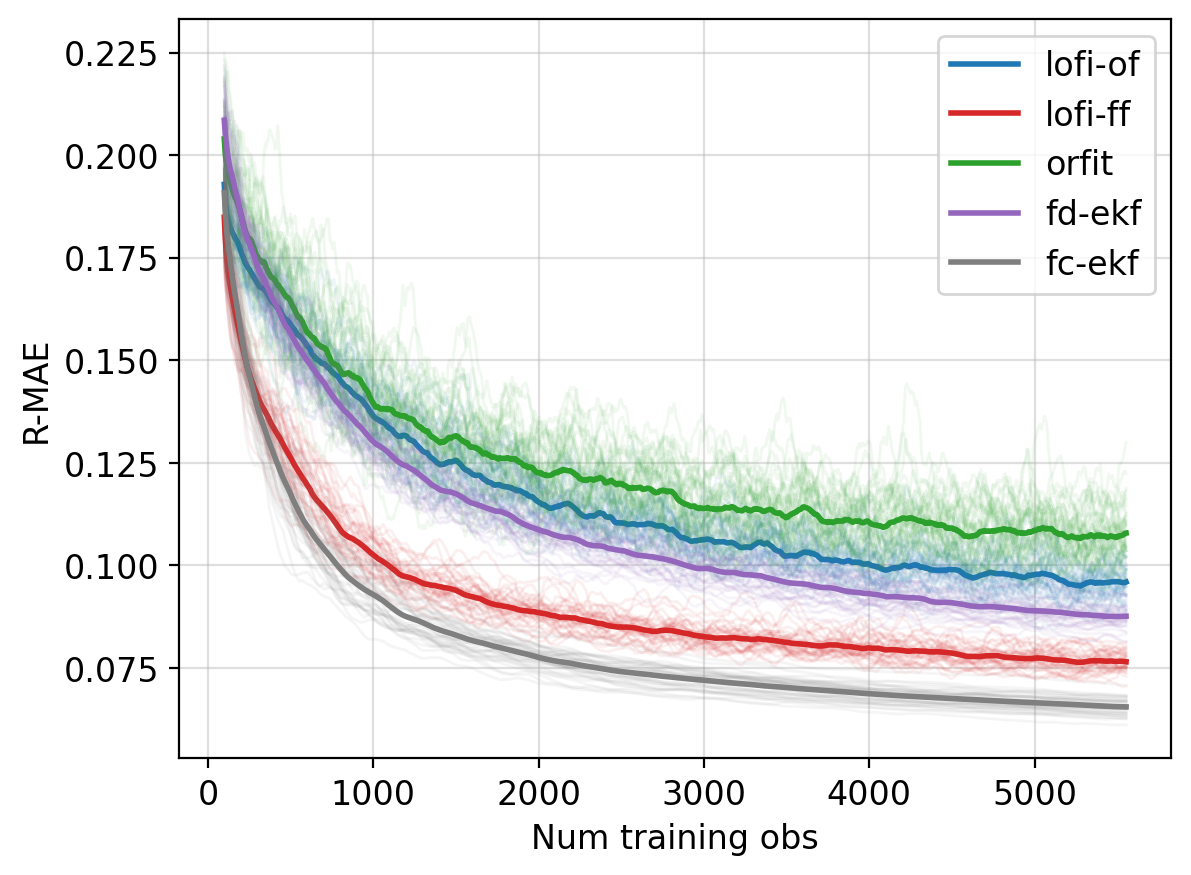

In [120]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/bounds-{dataset}.pdf")

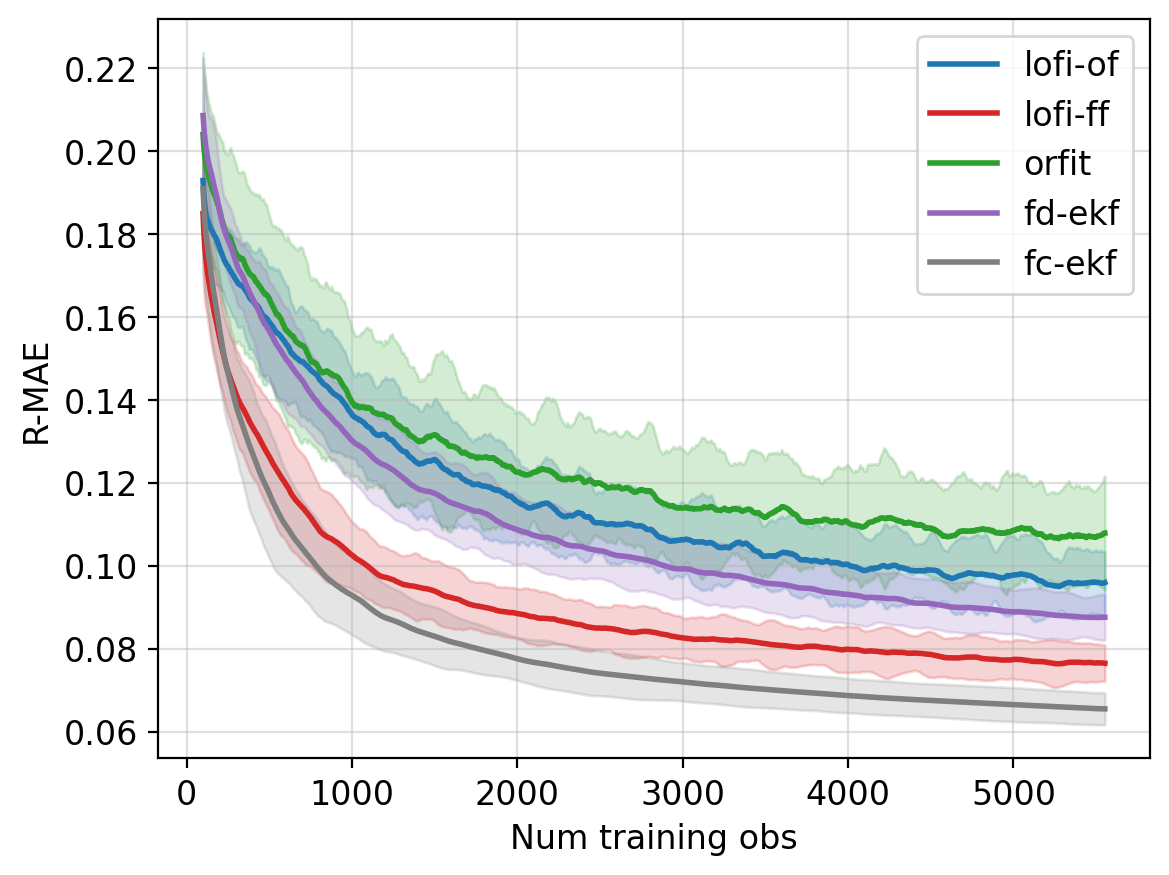

In [121]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/sims-{dataset}.pdf")

In [39]:
last_rmae = {
    key: collection[key].iloc[-1]
    for key in collection
}
last_rmae = pd.DataFrame(last_rmae)

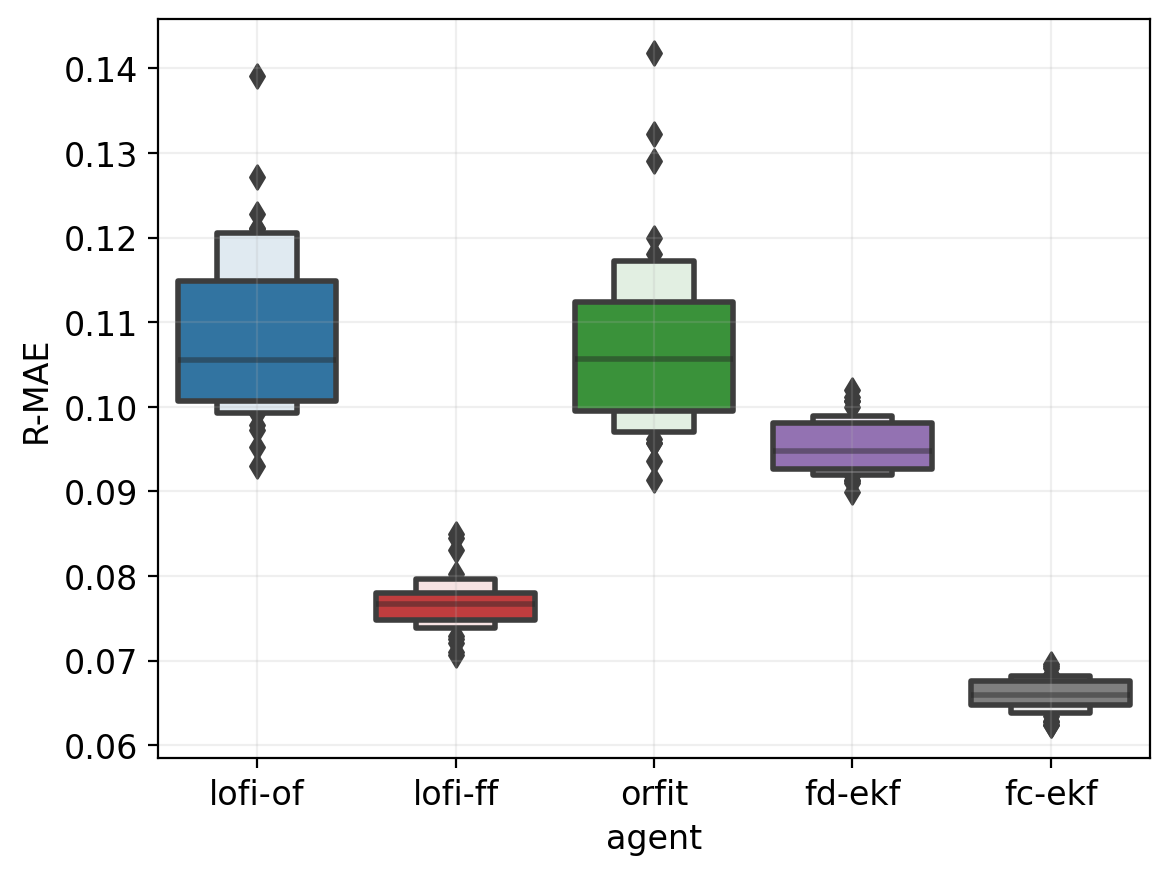

In [40]:
sns.boxenplot(
    x="agent",
    y="R-MAE",
    palette=colors,
    data=last_rmae.melt(var_name="agent", value_name="R-MAE")
)
plt.grid(alpha=0.2)
plt.savefig(f"output/last-metric-{dataset}.pdf")

### Plot rolling RMAE on the one-step-ahead posterior predictive

In [41]:
collection = {
    agent: pd.DataFrame(res["osa-error"]).T
    for agent, res in sims.items()
}

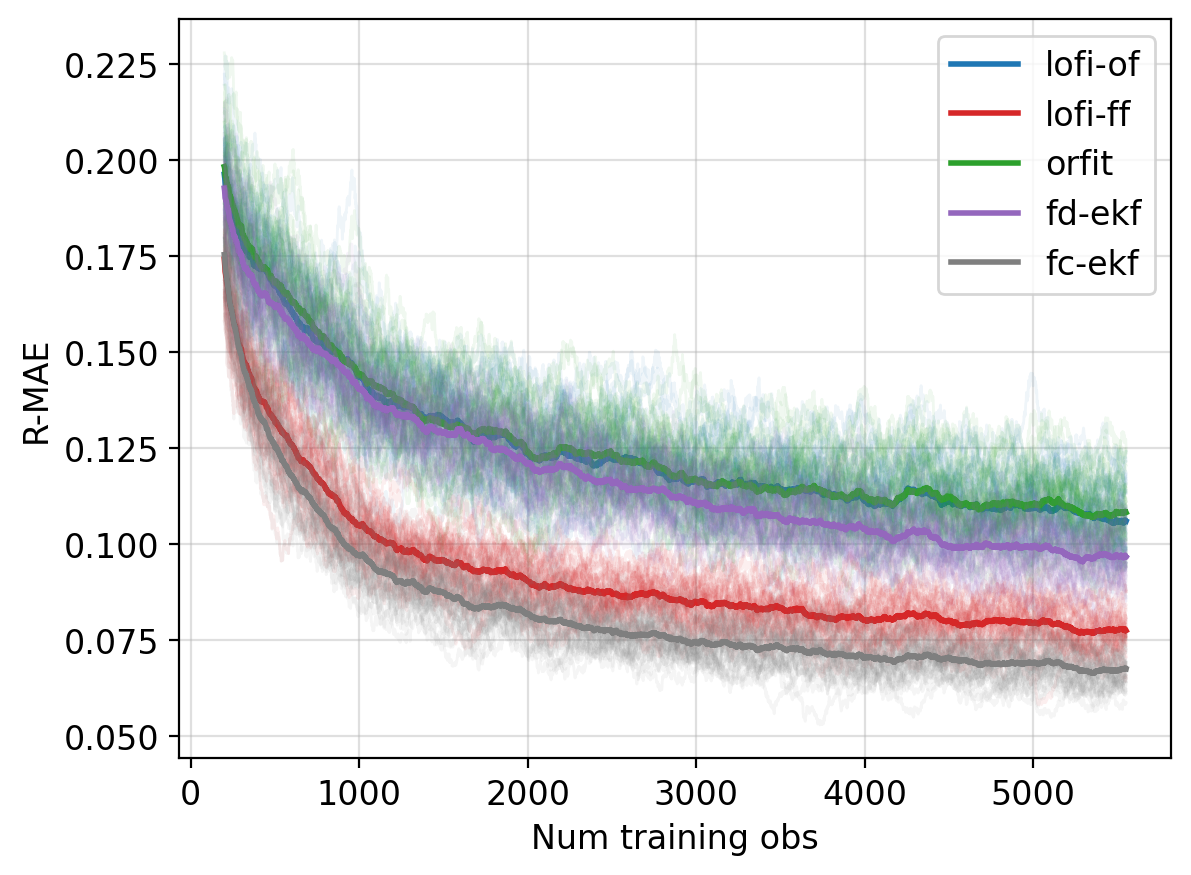

In [42]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-sims-{dataset}.pdf")

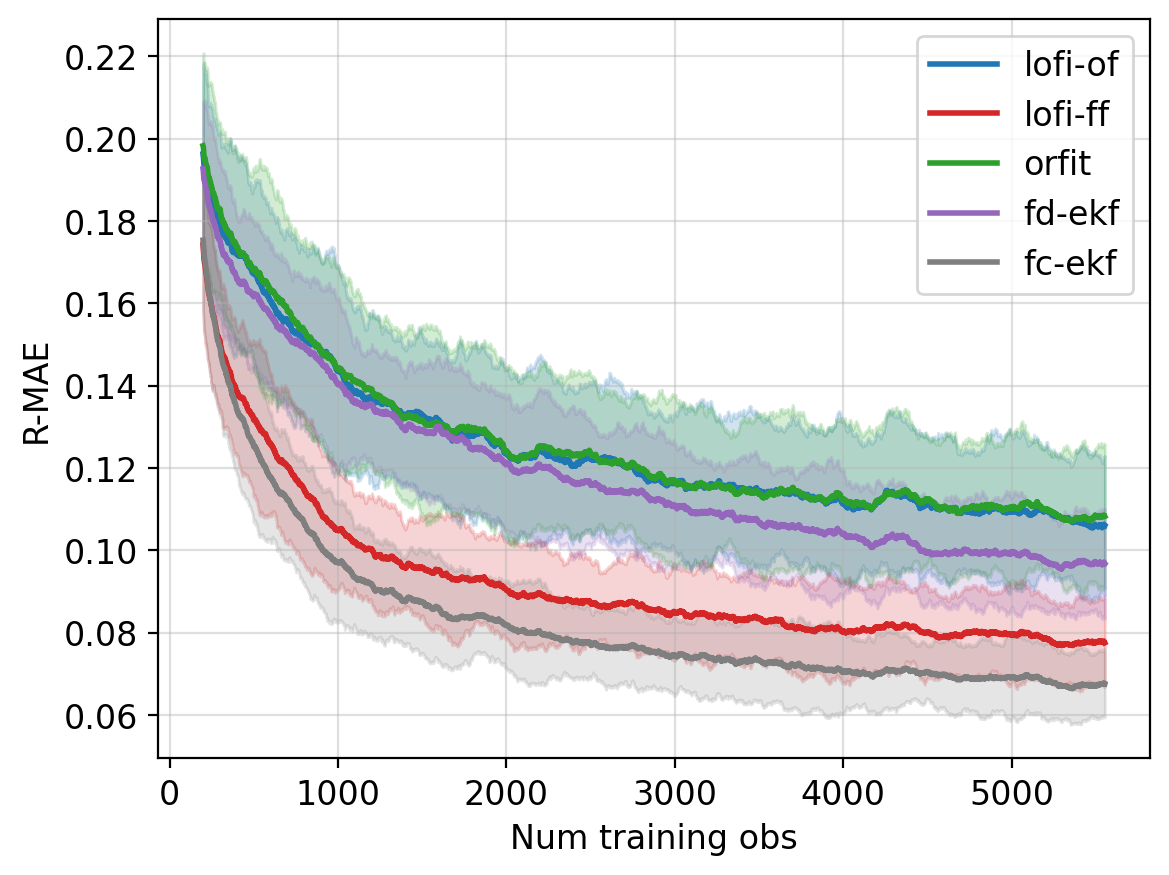

In [43]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-bounds-{dataset}.pdf")